# Predict Bike Sharing Demand with AutoGluon

An example of using AutoGluon on AWS Sagemaker.
AutoGluon is a useful tool that enables trying many different models initially and it can automatically help create an ensemble model from them. It has flexibility of selecting certain models and also doing hyperparameter search and tuning between them.

Here hyperparameter tuning is not shown. I tried some simple search but could not get much better than default values. Probably becuase feature engineering in this dataset is much more important and first good features engineering and cleaning should be done.

I tried some simple and quick features but more time can be spent to do better. Then it would make more sense to do more hyperparameter tuning.


Dataset has already been downloaded into the folder.

### Loading the libraries

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data visualization

Checking features and target of the train data

In [2]:
train = pd.read_csv("train.csv")
train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


First we change datetime feature from string into datetime object, and then transform it into year, month, day, hour, minute, second

In [4]:
train['datetime'] = pd.to_datetime(train['datetime'])
train.info()

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day

train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0,10886.0
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,0.0,0.0
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,0.0,0.0
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.0,0.0
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,0.0,0.0
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,0.0,0.0
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,0.0,0.0
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,0.0,0.0


We can note that no entry has minutes or seconds so we drop those columns/featurs

In [6]:
train = train.drop(['minute', 'second'], axis = 1)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


Now we check the test data and note that 'casual' and 'registered' features do not exist in it. Therefore we should not use them when training the data and will drop them also from the data.

In [7]:
test = pd.read_csv("test.csv")

test['datetime'] = pd.to_datetime(test['datetime'])
train.info()

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day

test['hour'] = test['datetime'].dt.hour

test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


In [8]:
train = train.drop(['casual', 'registered'], axis = 1)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


Checking the histogram of the features

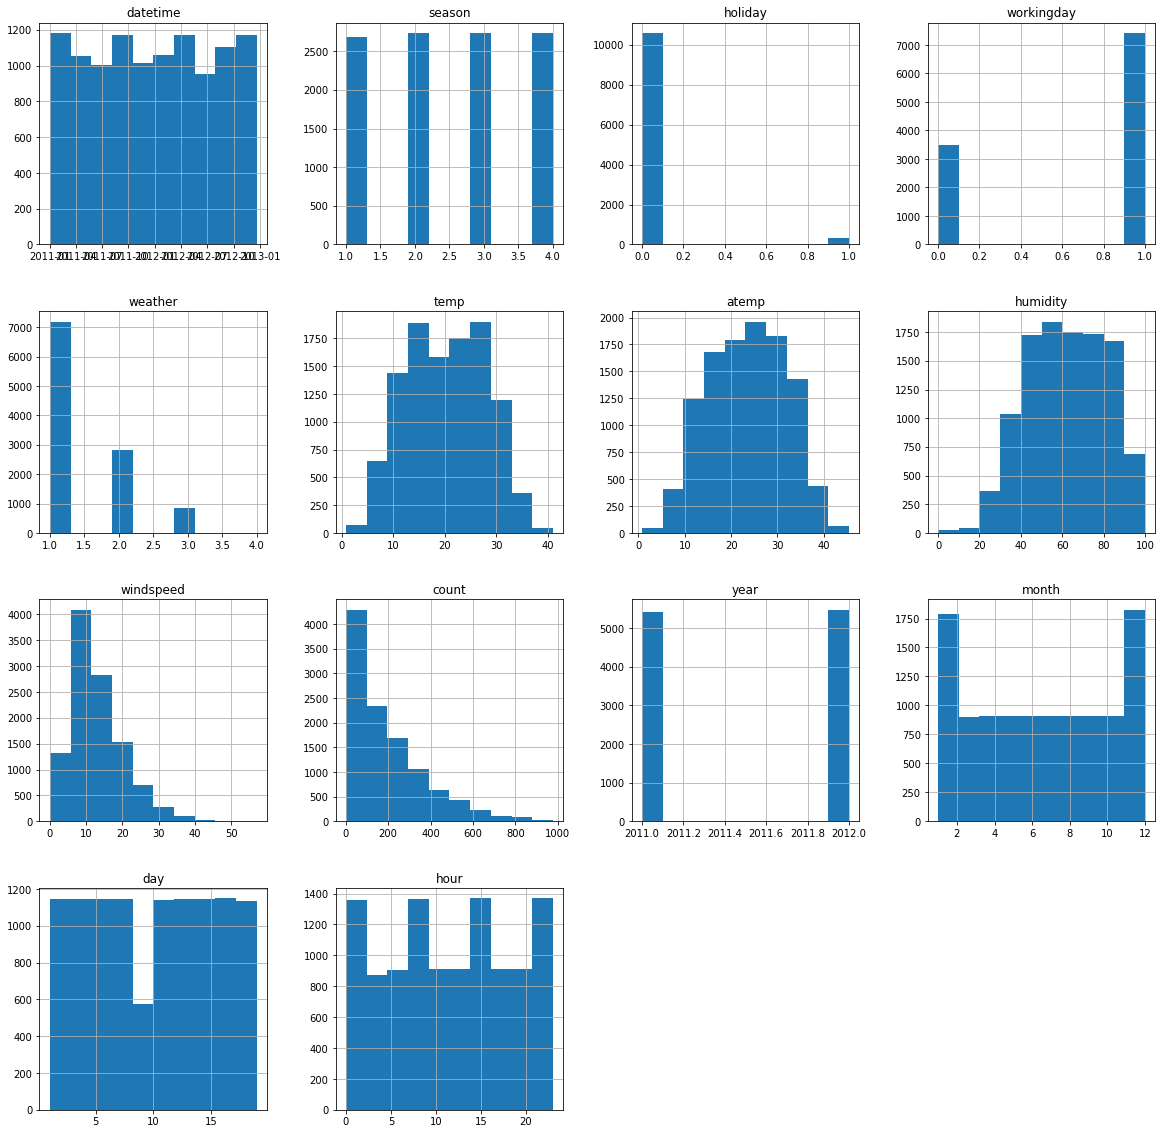

In [9]:
train.hist(figsize=(20, 20));

We can note that:
- weather, season, holiday, workingday, and even year seem to be categorical data. So we can change them into category data type.
- Also since holiday can affect the target/count, and day of the week and week of the year can have meaningful relation to holiday, we can create new features based on that

All changes should be done to both train and test dataset.

Later AutoGluon would make its own decision on how to work with different features.

In [10]:
train['dow'] = train['datetime'].dt.dayofweek
train['woy'] = train['datetime'].dt.isocalendar().week


test['dow'] = test['datetime'].dt.dayofweek
test['woy'] = test['datetime'].dt.isocalendar().week


train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
train["workingday"] = train["workingday"].astype("category")
train["holiday"] = train["holiday"].astype("category")
train["year"] = train["year"].astype("category")

test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")
test["workingday"] = test["workingday"].astype("category")
test["holiday"] = test["holiday"].astype("category")
test["year"] = test["year"].astype("category")

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dow,woy
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5,52
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5,52
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,5,52
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,5,52
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,5,52


## Set up the model

We setup the model by assigning the count as label, we set it as a regression model and use RMSE as the evaluation metric. 

In [11]:
predictor = TabularPredictor(label = "count", problem_type = "regression", eval_metric = "root_mean_squared_error").fit(train_data = train.drop(["datetime"], axis = 1), time_limit = 600, presets = "best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220810_130056/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220810_130056/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'UInt32Dtype()' as a data type
	Available Memory:                    3094.23 MB
	Train Data (Original)  Memory Usage: 0.81 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
Cannot interpret 'UInt32Dtype()' as a data type
Cannot interpret 'UInt32Dtype()' as a data type
Can

In [12]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -32.499611      21.713746  549.253811                0.000933           0.401481            3       True         16
1      WeightedEnsemble_L2  -32.726889      18.895636  350.317416                0.001237           0.883174            2       True          9
2     ExtraTreesMSE_BAG_L2  -32.736942      20.335995  401.526765                0.602875           8.361560            2       True         14
3          CatBoost_BAG_L2  -32.876870      19.846278  450.838684                0.113158          57.673478            2       True         13
4          LightGBM_BAG_L2  -33.021701      19.867484  414.056266                0.134363          20.891060            2       True         11
5   RandomForestMSE_BAG_L2  -33.252734      20.363089  421.371499         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -119.97880966975461,
  'KNeighborsDist_BAG_L1': -115.038459148802,

# Evaluate the model

First we can find the MSE of the best fitted model.
Then we write the predictions into the template of the submission and submit that to kaggle to get a score on the hidden test dataset.

In [13]:
predictions = predictor.predict(test.drop(["datetime"], axis = 1))
predictions.head()
predictions.describe()

count    6493.000000
mean      189.525436
std       173.785156
min         1.857529
25%        46.430859
50%       146.735550
75%       277.697388
max       898.979370
Name: count, dtype: float64

## Processing submission file to kaggle

- Load the template file.
- write the predictions from the model into the empty target column
- submit to kaggle and get a score


In [14]:
submission = pd.read_csv("sampleSubmission.csv")
submission["count"] = predictions
submission.to_csv("submission_simple_features.csv", index = False)

In [15]:
!kaggle competitions submit -c bike-sharing-demand -f submission_simple_features.csv -m "simple features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 267kB/s]
Successfully submitted to Bike Sharing Demand

In [16]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

fileName                        date                 description                          status    publicScore  privateScore  
------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_simple_features.csv  2022-08-10 13:17:22  simple features                      complete  0.45148      0.45148       


We got a score of 0.451, around rank 800 from 3400 participants of 7 years ago!